# 5. Varying N in Top-N Simulations

This notebook loads an existing Beer1pos data and runs it through the simulator with varying N (the number of precursor peaks selected for fragmentations) for Top-N DDA fragmentation. The results here correspond to Section 3.3 in the paper for the Beer1pos data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import pymzml
import math
import seaborn as sns

In [3]:
import sys
sys.path.append('..')

In [4]:
from vimms.Roi import RoiToChemicalCreator, make_roi
from vimms.DataGenerator import DataSource, PeakSampler, get_spectral_feature_database
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController
from vimms.TopNExperiment import get_params, run_serial_experiment, run_parallel_experiment
from vimms.PlotsForPaper import get_df, load_controller, compute_performance_scenario_2
from vimms.Common import *

In [5]:
set_log_level_debug()

## 1. Parameters

In [6]:
base_dir = 'example_data'
mzml_path = os.path.join(base_dir, 'beers', 'fragmentation', 'mzML')
file_name = 'Beer_multibeers_1_T10_POS.mzML'

experiment_name = 'beer1pos'
experiment_out_dir = os.path.abspath(os.path.join(base_dir, 'results', experiment_name, 'mzML'))

In [7]:
experiment_out_dir

'C:\\Users\\joewa\\Work\\git\\vimms\\examples\\example_data\\results\\beer1pos\\mzML'

In [8]:
min_rt = 3*60 # start time when compounds begin to elute in the mzML file
max_rt = 21*60

In [9]:
kde_min_ms1_intensity = 0 # min intensity to be selected for kdes
kde_min_ms2_intensity = 0

### a. ROI extraction parameters

In [10]:
roi_mz_tol = 10
roi_min_length = 1
roi_min_intensity = 0
roi_start_rt = min_rt
roi_stop_rt = max_rt

### b. Top-N parameters

In [11]:
isolation_window = 1   # the isolation window in Dalton around a selected precursor ion
ionisation_mode = POSITIVE
N = 10
rt_tol = 15
mz_tol = 10
min_ms1_intensity = 1.75E5 # minimum ms1 intensity to fragment

In [12]:
mzml_out = os.path.join(experiment_out_dir, 'simulated.mzML')

## 2. Train densities

In [13]:
ds = DataSource()
ds.load_data(mzml_path, file_name=file_name)

INFO   : DataSource                     : Loading Beer_multibeers_1_T10_POS.mzML


In [14]:
bandwidth_mz_intensity_rt=1.0
bandwidth_n_peaks=1.0
ps = get_spectral_feature_database(ds, file_name, kde_min_ms1_intensity, kde_min_ms2_intensity, min_rt, max_rt,
               bandwidth_mz_intensity_rt, bandwidth_n_peaks)

DEBUG  : PeakSampler                    : Extracted 7647 MS2 scans
DEBUG  : PeakSampler                    : Computing parent intensity proportions
DEBUG  : PeakSampler                    : Extracting scan durations
DEBUG  : PeakSampler                    : Training KDEs for ms_level=1
DEBUG  : PeakSampler                    : Retrieving mz_intensity_rt values from <vimms.DataGenerator.DataSource object at 0x00000233E649CA20>
INFO   : DataSource                     : Using values from scans
DEBUG  : PeakSampler                    : Retrieving n_peaks values from <vimms.DataGenerator.DataSource object at 0x00000233E649CA20>
DEBUG  : PeakSampler                    : Training KDEs for ms_level=2
DEBUG  : PeakSampler                    : Retrieving mz_intensity_rt values from <vimms.DataGenerator.DataSource object at 0x00000233E649CA20>
INFO   : DataSource                     : Using values from scans
DEBUG  : PeakSampler                    : Retrieving n_peaks values from <vimms.DataGener

## 3. Extract all ROIs

In [15]:
mzml_file = os.path.join(mzml_path, file_name)
good_roi, junk = make_roi(mzml_file, mz_tol=roi_mz_tol, mz_units='ppm', min_length=roi_min_length,
                          min_intensity=roi_min_intensity, start_rt=roi_start_rt, stop_rt=roi_stop_rt)

In [16]:
all_roi = good_roi + junk
len(all_roi)

266107

How many singleton and non-singleton ROIs?

In [17]:
len([roi for roi in all_roi if roi.n == 1])

185119

In [18]:
len([roi for roi in all_roi if roi.n > 1])

80988

Keep only the ROIs that can be fragmented above **min_ms1_intensity threshold**.

In [19]:
min_ms1_intensity

175000.0

In [20]:
keep = []
for roi in all_roi:
    if np.count_nonzero(np.array(roi.intensity_list) > min_ms1_intensity) > 0:
        keep.append(roi)

all_roi = keep
len(keep)

10079

Turn ROIs into chromatograms/chemicals

In [21]:
set_log_level_debug()
rtcc = RoiToChemicalCreator(ps, all_roi)

DEBUG  : RoiToChemicalCreator           :      0/ 10079
INFO   : RoiToChemicalCreator           : Found 10079 ROIs above thresholds


In [22]:
data = rtcc.chemicals
save_obj(data, os.path.join(experiment_out_dir, 'dataset.p'))

Saving <class 'list'> to C:\Users\joewa\Work\git\vimms\examples\example_data\results\beer1pos\mzML\dataset.p


## 4. Run Top-N Controller

In [23]:
set_log_level_warning()
pbar = False # turn off progress bar

In [24]:
Ns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
rt_tols = [15]

In [25]:
params = get_params(experiment_name, Ns, rt_tols, mz_tol, isolation_window, ionisation_mode, data, ps, 
                    min_ms1_intensity, min_rt, max_rt, experiment_out_dir, pbar)

N = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
rt_tol = [15]
len(params) = 28


In [26]:
experiment_out_dir

'C:\\Users\\joewa\\Work\\git\\vimms\\examples\\example_data\\results\\beer1pos\\mzML'

Run the experiments.

In [27]:
# %time run_serial_experiment(params)

Alternatively  since each simulated run is completely independent of the others, we can save time by running the different values of N in parallel. Here we use the [iparallel](https://ipyparallel.readthedocs.io/en/latest/) package. To do this, start a local parallel cluster with the following command:

$ ipcluster start -n 5

where 5 is the number of cores to use (for example).

In [28]:
%time run_parallel_experiment(params)

experiment_beer1pos_N_1_rttol_15
experiment_beer1pos_N_2_rttol_15
experiment_beer1pos_N_3_rttol_15
experiment_beer1pos_N_4_rttol_15
experiment_beer1pos_N_5_rttol_15
experiment_beer1pos_N_6_rttol_15
experiment_beer1pos_N_7_rttol_15
experiment_beer1pos_N_8_rttol_15
experiment_beer1pos_N_9_rttol_15
experiment_beer1pos_N_10_rttol_15
experiment_beer1pos_N_15_rttol_15
experiment_beer1pos_N_20_rttol_15
experiment_beer1pos_N_25_rttol_15
experiment_beer1pos_N_30_rttol_15
experiment_beer1pos_N_35_rttol_15
experiment_beer1pos_N_40_rttol_15
experiment_beer1pos_N_45_rttol_15
experiment_beer1pos_N_50_rttol_15
experiment_beer1pos_N_55_rttol_15
experiment_beer1pos_N_60_rttol_15
experiment_beer1pos_N_65_rttol_15
experiment_beer1pos_N_70_rttol_15
experiment_beer1pos_N_75_rttol_15
experiment_beer1pos_N_80_rttol_15
experiment_beer1pos_N_85_rttol_15
experiment_beer1pos_N_90_rttol_15
experiment_beer1pos_N_95_rttol_15
experiment_beer1pos_N_100_rttol_15
Wall time: 17min 50s


## 5. Analyse Results

Now we need to load the ground truth peaks found by xcms from each mzML file.
- P = peaks picked by XCMS from the full-scan file
- Q = peaks picked by XCMS from the fragmentation file

Peak picking was done using the script `extract_peaks.R` in the `example_data/results/ground_truth` folder. 

**Manual step: to generate the lists of ground truth peaks for evaluation, please run the R script on both the full-scan and simulated fragmentation files.**

Requirements:
- Ensure that XCMS3 has been installed: https://bioconductor.org/packages/release/bioc/html/xcms.html.

Steps for peak picking on simulated fragmentation files:
1. Ensure that fragmentation .mzML file are located in `examples\example_data\results\beer1pos`.
2. Open a new R window and run the R script `examples\example_data\results\beer1pos\extract_peaks.R`. The script will process any files found in an `mzML` folder relative to its current location.
3. The file `extracted_peaks_ms1.csv` will be created in the folder of step 2.

We have provided the peak-picking result for the full-scan file, but to do it manually, follow the same steps as above. 
1. Place your full-scan .mzML file in `examples\example_data\results\ground_truth\mzML`.
2. Open a new R window and run the R script `examples\example_data\results\ground_truth\extract_peaks.R`. The script will process any files found in an `mzML` folder relative to its current location.
3. The file `extracted_peaks_ms1.csv` will be created in the folder of step 2.

In [29]:
min_ms1_intensity = 0
rt_range = [(min_rt, max_rt)]
mz_range = [(0, math.inf)]
results_dir = os.path.join(base_dir, 'results', 'ground_truth', 'mzML')   
csv_file = os.path.join(results_dir, 'extracted_peaks_ms1.csv')
P_peaks_df = get_df(csv_file, min_ms1_intensity, rt_range, mz_range)

In [30]:
csv_file = os.path.join(experiment_out_dir, 'extracted_peaks_ms1.csv')
Q_peaks_df = get_df(csv_file, min_ms1_intensity, rt_range, mz_range)

In [31]:
fullscan_filename = 'Beer_multibeers_1_fullscan1.mzML'   
matching_mz_tol = 10 # ppm
matching_rt_tol = 30 # seconds

In [32]:
results = []
for N in Ns:
    for rt_tol in rt_tols:

        # load chemicals and check for matching
        chemicals = load_obj(os.path.join(experiment_out_dir, 'dataset.p'))           
        fragfile_filename = 'experiment_%s_N_%d_rttol_%d.mzML' % (experiment_name, N, rt_tol) 

        # load controller and compute performance
        controller = load_controller(experiment_out_dir, experiment_name, N, rt_tol)
        if controller is not None:
            tp, fp, fn, prec, rec, f1 = compute_performance_scenario_2(controller, chemicals, min_ms1_intensity,
                                                                       fullscan_filename, fragfile_filename,
                                                                       P_peaks_df, Q_peaks_df, matching_mz_tol, matching_rt_tol)
            print('%s N=%d rt_tol=%d tp=%d fp=%d fn=%d prec=%.3f rec=%.3f f1=%.3f' % (experiment_name, 
                N, rt_tol, tp, fp, fn, prec, rec, f1))
            res = (experiment_name, N, rt_tol, tp, fp, fn, prec, rec, f1)    
            results.append(res)  

Loading experiment_beer1pos_N_1_rttol_15
Matched 3678/10079 in fullscan data, 6573/10079 in fragmentation data
beer1pos N=1 rt_tol=15 tp=1183 fp=916 fn=2495 prec=0.564 rec=0.322 f1=0.410
Loading experiment_beer1pos_N_2_rttol_15
Matched 3678/10079 in fullscan data, 6552/10079 in fragmentation data
beer1pos N=2 rt_tol=15 tp=1532 fp=1155 fn=2146 prec=0.570 rec=0.417 f1=0.481
Loading experiment_beer1pos_N_3_rttol_15
Matched 3678/10079 in fullscan data, 6276/10079 in fragmentation data
beer1pos N=3 rt_tol=15 tp=1674 fp=1193 fn=2004 prec=0.584 rec=0.455 f1=0.512
Loading experiment_beer1pos_N_4_rttol_15
Matched 3678/10079 in fullscan data, 6025/10079 in fragmentation data
beer1pos N=4 rt_tol=15 tp=1741 fp=1195 fn=1937 prec=0.593 rec=0.473 f1=0.526
Loading experiment_beer1pos_N_5_rttol_15
Matched 3678/10079 in fullscan data, 5762/10079 in fragmentation data
beer1pos N=5 rt_tol=15 tp=1817 fp=1166 fn=1861 prec=0.609 rec=0.494 f1=0.546
Loading experiment_beer1pos_N_6_rttol_15
Matched 3678/10079 i

In [33]:
result_df = pd.DataFrame(results, columns=['experiment', 'N', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1'])

### Plot precision, recall, f1

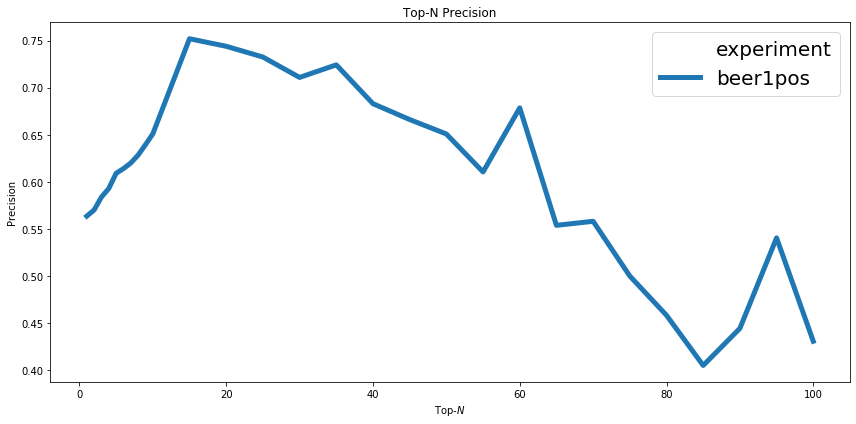

In [34]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='N', y='Prec', hue='experiment', legend='brief', data=result_df)
plt.title('Top-N Precision')
for l in ax.lines:
    plt.setp(l, linewidth=5)
plt.ylabel('Precision')
plt.xlabel(r'Top-$N$')
plt.legend(prop={'size': 20})
plt.tight_layout()

fig_out = os.path.join(experiment_out_dir, 'topN_precision.png')
plt.savefig(fig_out, dpi=300)

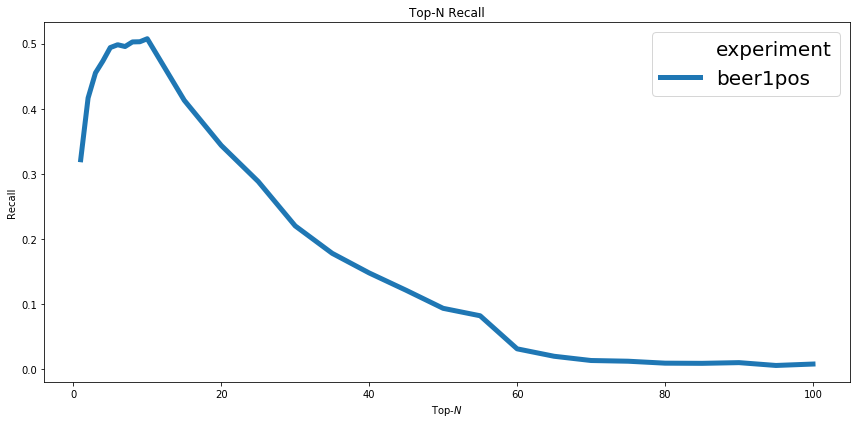

In [35]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='N', y='Rec', hue='experiment', legend='brief', data=result_df)
plt.title('Top-N Recall')
for l in ax.lines:
    plt.setp(l, linewidth=5)
plt.ylabel('Recall')
plt.xlabel(r'Top-$N$')
plt.legend(prop={'size': 20})
plt.tight_layout()

fig_out = os.path.join(experiment_out_dir, 'topN_recall.png')
plt.savefig(fig_out, dpi=300)

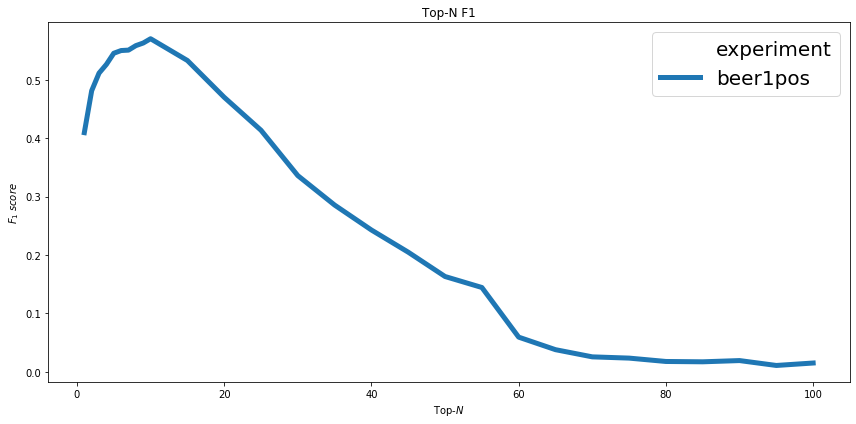

In [36]:
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='N', y='F1', hue='experiment', legend='brief', data=result_df)
plt.title('Top-N F1')
for l in ax.lines:
    plt.setp(l, linewidth=5)
plt.ylabel(r'$F_{1}\;score$')
plt.xlabel(r'Top-$N$')
plt.legend(prop={'size': 20})
plt.tight_layout()

fig_out = os.path.join(experiment_out_dir, 'topN_f1.png')
plt.savefig(fig_out, dpi=300)